# 프로젝트: 뉴스기사 요약해보기

In [4]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [5]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기

In [6]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [7]:
data.sample(10)

,headlines,text
38677,Kejriwal's sit-in is a mockery of democracy: D...,Delhi BJP President Manoj Tiwari today called ...
24439,HIV positive man hangs self after hospitals de...,An HIV positive man in Odisha committed suicid...
85778,"Akshay holds a lantern, lota in Toilet-Ek Prem...",Actor Akshay Kumar can be seen holding a lota ...
10677,I'll stick to getting trolled: Kohli clarifies...,After being trolled for asking a fan to leave ...
64318,Those used to 2G scam will object to legitimat...,Slamming Congress Vice-President Rahul Gandhi ...
35444,John Abraham opts out of 'Romeo Akbar Walter':...,"As per reports, John Abraham has opted out of ..."
81157,Unfair to subject my boyfriend to harsh commen...,Ileana D'Cruz has said that it's unfair to sub...
13297,Uber driver waits for 1.5 hrs with women at ni...,A woman's tweet praising an Uber driver named ...
60901,New brain implant claims to boost human memory...,A US-based study on 20 volunteers claimed to b...
48280,SA captain fined 20% game fee for slow over-ra...,South Africa captain Aiden Markram has been fi...


# Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [8]:
data.shape

(98401, 2)

In [9]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [10]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [11]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 텍스트 정규화와 불용어 제거

- 직접 눈으로 단어를 몇개 보면서 전처리 방식을 수정하였다.
-  '&' -> ' and '로,  \' -> '로 교체
- A&B일 경우를 고려해 ' and '로 전처리 한것을 감안해 다중 공백 제거하는 전처리를 추가하였다
- 불용어는 no나 not 같은 부정어들까지 사라지게 하므로 일단은 불용어는 제거하지 않았다

In [12]:
data.sample(5)

,headlines,text
19126,Feel deliberately sidelined by mainstream dire...,Actor Ranvir Shorey has said that he feels he ...
46794,EPFO lowers interest rate to 8.55% for 2017-18,The Employees' Provident Fund Organisation (EP...
54301,Being called former child star is derogatory: ...,"Actor Dylan Sprouse, known for acting with his..."
70489,UK govt grants itself power to bypass parliame...,Prime Minister Theresa May-led UK government o...
39446,Two-time champion Sharapova crashes out of Fre...,Two-time French Open winner Maria Sharapova ha...


In [13]:
data.headlines.sample(5).tolist()

["Sridevi played role of Rajinikanth's stepmother at age 13",
 'Katy Perry posts pic of nails painted with cryptocurrencies',
 'Centre slams UN expert who criticised Swachh Bharat Mission',
 'Chapecoense win first title since Colombia air crash',
 "Buffett's Berkshire Hathaway reports first loss in 9 years"]

In [14]:
data.text.sample(5).tolist()

['Talking about his memoir \'An Unsuitable Boy\', Karan Johar said writing things that he didn\'t want to address and share opened up his soul even more. He added, "Sometimes, talking...conversing helps." The memoir included chapters where Karan and his co-writer Poonam Saxena described his fallout with Kajol and also addressed the filmmaker\'s sexual orientation.',
 'India ranked fourth in the list of top 10 target countries for Web Application Attacks globally since November 2017, according to Akamai Technologies. Registering over 2.8 crore attacks, India also ranked eighth in the list of Web Application Attack source countries globally. Further, Akamai recorded a 16% increase in the number of Distributed Denial of Service (DDoS) attacks since 2017.',
 'US lawmaker Mike Quigley has proposed \'Communications Over Various Feeds Electronically For Engagement\' (COVFEFE) Act to require preservation of President Donald Trump\'s tweets and other social media interactions. "If the President

In [15]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [16]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [17]:
from tqdm import tqdm, trange

tqdm.pandas()

In [18]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('\"','', sentence) # 쌍따옴표 " 제거
    
    sentence = re.sub("&"," and ", sentence) # & -> and로 교체
    sentence = re.sub("\'","'", sentence) # \' -> '로 교체
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub(' +', ' ', sentence) # 다중공백 제거
    # sentence = ' '.join(sentence.split())
     
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

불용어에 no, not 같은 단어들이 있어서 일단 불용어는 제거하지 않는다

In [19]:
clean_text = data['text'].progress_apply(lambda x: preprocess_sentence(x, False)).tolist()

print("text 전처리 후 결과: ", clean_text[:5])

100%|██████████| 98360/98360 [00:23<00:00, 4266.45it/s]

text 전처리 후 결과:  ['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more', 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their sevent

In [20]:
clean_headlines = data['headlines'].progress_apply(lambda x: preprocess_sentence(x, False)).tolist()

print("headline 전처리 후 결과: ", clean_headlines[:5])

100%|██████████| 98360/98360 [00:17<00:00, 5627.59it/s]

headline 전처리 후 결과:  ['upgrad learner switches to career in ml and al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [21]:
# 원본을 news에 저장해두고 오류 발생시 다시 사용하고자 한다
news = data.copy()

In [22]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [23]:
news

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [24]:
data.head()

,headlines,text
0,upgrad learner switches to career in ml and al...,saurav kant an alumnus of upgrad and iiit pg p...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...


In [25]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.195445302968686
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.310481903212688


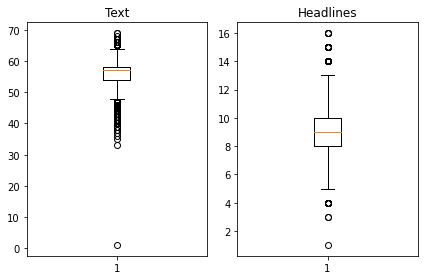

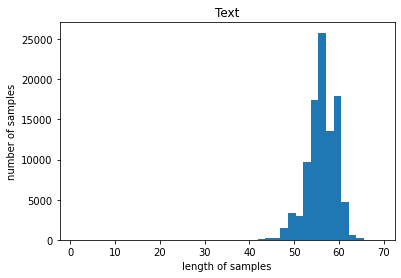

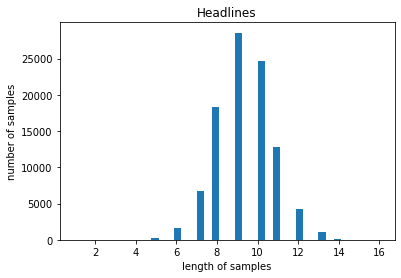

In [27]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 이상치 제거

In [41]:
np.argmin(text_len)

52

In [42]:
data.iloc[52]

headlines    headlines
text              text
Name: 52, dtype: object

In [43]:
np.quantile(text_len, 0.25)

54.0

In [44]:
data.shape

(98360, 2)

In [45]:
data.drop(52, inplace=True)

In [46]:
data.shape

(98359, 2)

텍스트의 최소 길이 : 33
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.19600646610885
요약의 최소 길이 : 3
요약의 최대 길이 : 16
요약의 평균 길이 : 9.310566394534307


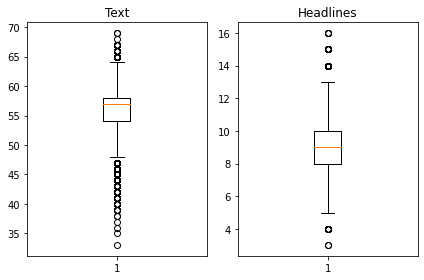

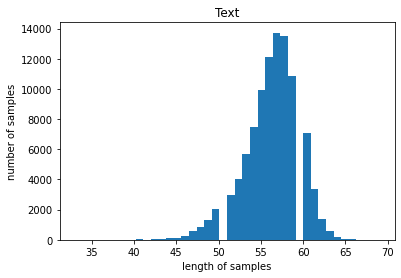

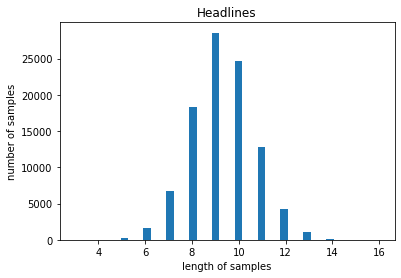

In [47]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [48]:
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))

텍스트의 최대 길이 : 69
요약의 최대 길이 : 16


In [55]:
text_max_len = 60
summary_max_len = 15

In [56]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [57]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.943787553757155
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999593326487662


### text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외

In [58]:
data.shape

(98359, 2)

In [59]:
c1 = data['headlines'].apply(lambda x: len(x.split())) <= summary_max_len
c2 = data['text'].apply(lambda x: len(x.split())) <= text_max_len

data = data.loc[c1 & c2]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 92826


### 시작 토큰과 종료 토큰 추가하기

In [60]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

/tmp/ipykernel_83/4081104566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
/tmp/ipykernel_83/4081104566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml and al...,saurav kant an alumnus of upgrad and iiit pg p...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml and al...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [246]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [247]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[78246 22336 32166 ... 34539 56656 21372]


In [248]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [249]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18565


In [250]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 74261
훈련 레이블의 개수 : 74261
테스트 데이터의 개수 : 18565
테스트 레이블의 개수 : 18565


### 정수 인코딩

In [251]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)

In [252]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68179
등장 빈도가 6번 이하인 희귀 단어의 수: 46506
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21673
단어 집합에서 희귀 단어의 비율: 68.21161941360243
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.27145274988354


In [253]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [254]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1002, 4, 10016, 4823, 31, 7, 68, 308, 82, 114, 1799, 2365, 168, 117, 41, 2550, 2, 6249, 43, 3809, 311, 18, 1922, 1, 5884, 4, 52, 3, 1272, 37, 12, 275, 1, 1948, 599, 76, 170, 13, 2071, 2, 4666, 5884, 1074, 7, 32, 2194, 1623, 1002, 28, 27, 610, 268, 15, 101, 392, 2, 2456, 1, 2071], [3072, 57, 4039, 6, 124, 387, 1, 45, 50, 566, 2881, 2, 601, 125, 8, 67, 1624, 20, 3072, 104, 6, 549, 1, 30, 54, 162, 7, 1075, 20, 1, 104, 56, 4, 481, 605, 159, 297, 169, 20, 16, 520, 355, 9096, 16, 302, 6250, 5885, 11, 809, 20, 3072, 357, 57, 3], [3109, 111, 191, 103, 38, 1, 292, 8467, 2, 2775, 466, 1341, 1334, 2, 895, 120, 3682, 867, 13065, 13066, 9, 15048, 362, 73, 5, 467, 49, 53, 21, 1258, 91, 66, 5, 200, 91, 313, 311, 93, 91, 4738, 3, 13966, 1189, 6189, 21, 13967, 91, 15663, 7, 3736, 5, 81, 21, 26, 1156, 7815, 14, 34]]


In [255]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [256]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29413
등장 빈도가 5번 이하인 희귀 단어의 수: 19352
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10061
단어 집합에서 희귀 단어의 비율: 65.79403665046068
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.854241729446446


In [257]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4787, 742, 178, 4981, 465, 730, 10, 1535, 4982], [1, 2273, 2055, 210, 44, 3, 739, 214, 5, 93], [1, 320, 279, 151, 22, 38, 13, 743, 1250], [1, 150, 147, 3182, 16, 690, 32, 2712, 1151, 691], [1, 1142, 1854, 2713, 3964, 4, 377, 4635, 4636]]
target
decoder  [[4787, 742, 178, 4981, 465, 730, 10, 1535, 4982, 2], [2273, 2055, 210, 44, 3, 739, 214, 5, 93, 2], [320, 279, 151, 22, 38, 13, 743, 1250, 2], [150, 147, 3182, 16, 690, 32, 2712, 1151, 691, 2], [1142, 1854, 2713, 3964, 4, 377, 4635, 4636, 2]]


In [261]:
decoder_target_test[:5]

[[60, 602, 6, 6934, 784, 7, 1327, 154, 3518, 8, 2],
 [804, 2880, 258, 1614, 17, 3801, 30, 1798, 2],
 [1719, 935, 253, 8, 3, 4229, 348, 16, 291, 2],
 [99, 53, 9381, 1954, 531, 10, 434, 935, 2],
 [50, 3545, 110, 425, 15, 110, 1335, 5387, 32, 2]]

In [74]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74261
훈련 레이블의 개수 : 74261
테스트 데이터의 개수 : 18565
테스트 레이블의 개수 : 18565


### 패딩하기

pre로 하면 어떻게 될까?

In [75]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델 설계하기

- __모델 선정 이유__ 
    - lstm은 자연어 처리에서 대체로 좋은 성능을 내므로 lstm모델을 선정했고
    - 요약 모델을 할때 seq2seq를 사용하므로 이를 활용하였고 
    - attention은 lstm의 long term dependency 문제를 해결하기 위해 활용하였다
    
- __Metrics 선정 이유__
    - 요약 모델의 평가시 Rouge score를 많이 활용한다하여 이를 사용해보고자 하였으나 시간상의 이유로 활용하지 못했고
    - 대신에 직접 샘플을 통해 비교를 진행하였다
    
- __Loss 선정 이유__ 
    - sparse categorical crossentropy
    - seq2seq는 결국 10000개의 단어중에서 다음 단어를 예측하는 문제로 바뀌므로 이에따라 sparse categorical crossentropy를 선정하였다

In [78]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

디코더 설계

In [79]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [80]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [82]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [83]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
291/291 [==============================] - 43s 125ms/step - loss: 4.5906 - val_loss: 4.2521
Epoch 2/50
291/291 [==============================] - 36s 124ms/step - loss: 4.1058 - val_loss: 3.9757
Epoch 3/50
291/291 [==============================] - 37s 126ms/step - loss: 3.8341 - val_loss: 3.7750
Epoch 4/50
291/291 [==============================] - 37s 127ms/step - loss: 3.6293 - val_loss: 3.5806
Epoch 5/50
291/291 [==============================] - 37s 128ms/step - loss: 3.4555 - val_loss: 3.4742
Epoch 6/50
291/291 [==============================] - 37s 129ms/step - loss: 3.3106 - val_loss: 3.3833
Epoch 7/50
291/291 [==============================] - 38s 130ms/step - loss: 3.1854 - val_loss: 3.2924
Epoch 8/50
291/291 [==============================] - 38s 130ms/step - loss: 3.0760 - val_loss: 3.2266
Epoch 9/50
291/291 [==============================] - 38s 130ms/step - loss: 2.9820 - val_loss: 3.1705
Epoch 10/50
291/291 [==============================] - 38s 131ms/step - l

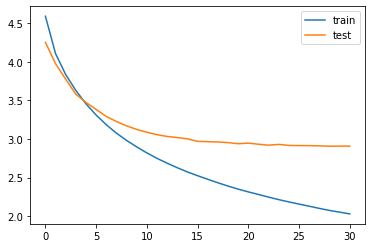

In [84]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 그래프를 통해 train loss와 val loss가 감소하는 것을 볼 수 있다

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [85]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [87]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [89]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [94]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence.strip()

모델 테스트하기

In [95]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i>2):
            temp = temp + tar_index_to_word[i]+' '
    return temp.strip()

In [96]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : uk queen elizabeth lingerie supplier and has been fired over the revelation of personal details about royal by the firm founder june in her autobiography the year old founder said losing the royal warrant absolutely killed her and that she regretted not being wise enough to mention of the royals in her autobiography 
실제 요약 : queen lingerie supplier fired for leaking personal details
예측 요약 : uk fires uk founder of stealing over death


원문 : aaj se teri the first song from the akshay kumar sonam kapoor and radhika apte starrer padman has been released the song has been composed by amit trivedi with vocals by arijit singh and lyrics by kausar munir directed by balki padman is scheduled to release on january 
실제 요약 : first song from akshay kumar starrer padman released
예측 요약 : song from akshay kumar starrer padman released


원문 : hyderabad university students on thursday burnt the copies of the justice commission report which attributed the suicide by research scholar rohith vemula to

In [191]:
encoder_input_test.shape

(18565, 60)

In [193]:
summerize_test = []
for i in trange(len(encoder_input_test)):
    tmp = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    summerize_test.append(tmp)

  9%|▉         | 1677/18565 [12:38<2:07:21,  2.21it/s]


KeyboardInterrupt: 

- stopwords를 제거하지 않았더니 상당히 잘 요약하는 것으로 보인다
- 모든 test_data를 번역한 뒤에 이를 활용해서 ROUGE SCORE를 구해보려 했으나 시간이 너무 오래 걸려서 하지 못했다

In [196]:
len(summerize_test)

1677

In [199]:
seq2text(encoder_input_test[0])

'sharing report on the us plans to revoke work visas for spouses of visa holders congress president rahul gandhi tweeted there are some things hug can buy for visas you are on your own the proposed rules will block spouses of around indians working on visas in the us from seeking employment or starting their business '

In [200]:
summerize_test[0]

'us visa rahul asks pm modi to discuss indira cooperation'

### Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

- 너무 적은 문장의 경우에는 요약을 못한다

In [122]:
import requests
from summa.summarizer import summarize

In [141]:
text = news.text[0]

In [142]:
text

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [144]:
print('Summary:')
print(summarize(text, words=15))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [146]:
news['summa_summarize'] = news['text'].progress_apply(lambda x: summarize(x, words=15))

100%|██████████| 98360/98360 [01:43<00:00, 951.59it/s]


In [149]:
news['summa_summarize'].iloc[-n_of_val:]

79831    Amitabh Bachchan has revealed that he wrestled...
79832                                                     
79833    RJD supremo Lalu Prasad Yadav on Wednesday off...
79834    Notably, Segal continued to officiate the matc...
79835    However, reports suggest users will not be abl...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    Michael B Jordan will reportedly play the lead...
98399    The video also shows a TV airing a news confer...
98400                                                     
Name: summa_summarize, Length: 18565, dtype: object

In [150]:
news.shape

(98360, 3)

In [151]:
data.shape

(92826, 4)

In [156]:
all_data = data.merge(news, how='left', right_index=True, left_index=True, suffixes=['','_raw'])

In [157]:
all_data.shape

(92826, 7)

In [160]:
test_data = all_data.iloc[-n_of_val:]

In [319]:
samples = test_data.sample(10)

In [320]:
samples

,headlines,text,decoder_input,decoder_target,headlines_raw,text_raw,summa_summarize
97116,indian led team develops solar powered electro...,scientists at the university of glasgow led by...,sostoken indian led team develops solar powere...,indian led team develops solar powered electro...,Indian-led team develops solar-powered 'electr...,Scientists at the University of Glasgow led by...,Scientists at the University of Glasgow led by...
87957,air india to raise crore through sale of prope...,state run air india plans to raise around cror...,sostoken air india to raise crore through sale...,air india to raise crore through sale of prope...,Air India to raise Ã¢ÂÂ¹80 crore through sale...,State-run Air India plans to raise around Ã¢Â...,State-run Air India plans to raise around Ã¢Â...
87280,linkedin co founder leads million funding in c...,linkedin co founder reid hoffman has led milli...,sostoken linkedin co founder leads million fun...,linkedin co founder leads million funding in c...,LinkedIn Co-founder leads $30 million funding ...,LinkedIn Co-founder Reid Hoffman has led a $30...,Microsoft Co-founder and the world's richest p...
96432,govt launches online film certification system,the union government on monday launched cinepr...,sostoken govt launches online film certificati...,govt launches online film certification system...,Govt launches Online Film Certification System,The Union government on Monday launched 'e-Cin...,The Union government on Monday launched 'e-Cin...
83227,india to draft law to safeguard interests in a...,india is currently drafting policy to safeguar...,sostoken india to draft law to safeguard inter...,india to draft law to safeguard interests in a...,India to draft law to safeguard interests in A...,India is currently drafting a policy to safegu...,India is currently drafting a policy to safegu...
87405,which are some of the longest bridges in india,the kilometre long dhola sadiya bridge in assa...,sostoken which are some of the longest bridges...,which are some of the longest bridges in india...,Which are some of the longest bridges in India?,The 9.15-kilometre long Dhola-Sadiya bridge in...,The 9.15-kilometre long Dhola-Sadiya bridge in...
97707,no fatwa was issued against singer nahid afrin...,after several media reports claiming muslim cl...,sostoken no fatwa was issued against singer na...,no fatwa was issued against singer nahid afrin...,No 'fatwa' was issued against singer Nahid Afr...,After several media reports claiming 46 Muslim...,"The leaflet, based on which media had reported..."
92812,black jesus kills in california shouts allahu ...,an african american gunman nicknamed black jes...,sostoken black jesus kills in california shout...,black jesus kills in california shouts allahu ...,"'Black Jesus' kills 3 in California, shouts Al...",An African-American gunman nicknamed 'Black Je...,An African-American gunman nicknamed 'Black Je...
98046,arrest of stayzilla founder disturbing says in...,chairman of the confederation of indian indust...,sostoken arrest of stayzilla founder disturbin...,arrest of stayzilla founder disturbing says in...,"Arrest of Stayzilla Founder disturbing, says i...",Chairman of the Confederation of Indian Indust...,Chairman of the Confederation of Indian Indust...
98004,national racing champ charred to death as car ...,national racing champion ashwin sundar and his...,sostoken national racing champ charred to deat...,national racing champ charred to death as car ...,National racing champ charred to death as car ...,National racing champion Ashwin Sundar and his...,National racing champion Ashwin Sundar and his...


# 테스트

- raw 문장에서 한번에 예측까지 하는 함수를 만들었고 이를 활용하여 전체 예측과정을 수행하였다
- 완전 새로운 뉴스데이터를 가져오려하였으나 용량 및 길이등의 문제로 test data(validation) 에서 샘플링을 하였다

In [372]:
def make_summary(text):
    pp = preprocess_sentence(text, False)
    ppd = src_tokenizer.texts_to_sequences([pp])
    ps = pad_sequences(ppd, maxlen=text_max_len, padding='post')
    result = decode_sequence(ps.reshape(1, text_max_len))
    return result

In [373]:
results = []
for text in samples.text_raw:
    result = make_summary(text)
    results.append(result)

In [374]:
samples['summary'] = results

In [375]:
samples.head()

,headlines,text,decoder_input,decoder_target,headlines_raw,text_raw,summa_summarize,summary
97116,indian led team develops solar powered electro...,scientists at the university of glasgow led by...,sostoken indian led team develops solar powere...,indian led team develops solar powered electro...,Indian-led team develops solar-powered 'electr...,Scientists at the University of Glasgow led by...,Scientists at the University of Glasgow led by...,india ceo pay hike for indian exchange pay for
87957,air india to raise crore through sale of prope...,state run air india plans to raise around cror...,sostoken air india to raise crore through sale...,air india to raise crore through sale of prope...,Air India to raise Ã¢ÂÂ¹80 crore through sale...,State-run Air India plans to raise around Ã¢Â...,State-run Air India plans to raise around Ã¢Â...,couple to buy india for crore in india
87280,linkedin co founder leads million funding in c...,linkedin co founder reid hoffman has led milli...,sostoken linkedin co founder leads million fun...,linkedin co founder leads million funding in c...,LinkedIn Co-founder leads $30 million funding ...,LinkedIn Co-founder Reid Hoffman has led a $30...,Microsoft Co-founder and the world's richest p...,ceo of ceo who quit as ceo of hindostan report
96432,govt launches online film certification system,the union government on monday launched cinepr...,sostoken govt launches online film certificati...,govt launches online film certification system...,Govt launches Online Film Certification System,The Union government on Monday launched 'e-Cin...,The Union government on Monday launched 'e-Cin...,govt to sell child accident in delhi ncr
83227,india to draft law to safeguard interests in a...,india is currently drafting policy to safeguar...,sostoken india to draft law to safeguard inter...,india to draft law to safeguard interests in a...,India to draft law to safeguard interests in A...,India is currently drafting a policy to safegu...,India is currently drafting a policy to safegu...,india to be part of doing business due to lack...


In [376]:
for i in range(10):
    print("원문 :", samples.text_raw.tolist()[i])
    print("실제 요약 :", samples.headlines.tolist()[i])
    print("예측 요약 :", samples.summary.tolist()[i])
    print("추출적 요약 :", samples.summa_summarize.tolist()[i])
    print("\n")

원문 : Scientists at the University of Glasgow led by Indian scientist Ravinder Dahiya have devised a synthetic skin that uses graphene to generate electricity via solar energy. The 'electronic skin' mimicks various sensory receptors found in human skin to give robots a sense of touch. The goal is to use the technology to make energy-autonomous prosthetic limbs, said Dahiya.
실제 요약 : indian led team develops solar powered electronic skin
예측 요약 : india ceo pay hike for indian exchange pay for
추출적 요약 : Scientists at the University of Glasgow led by Indian scientist Ravinder Dahiya have devised a synthetic skin that uses graphene to generate electricity via solar energy.


원문 : State-run Air India plans to raise around Ã¢ÂÂ¹80 crore through sale of its seven properties, which include land parcels and flats. Air India has been in possession of some properties which are lying vacant and unused. As per its financial restructuring plan approved in 2012, Air India is required to monetise its ass

In [377]:
# !pip install rouge-score

In [378]:
from rouge_score import rouge_scorer

In [379]:
reference_summaries = samples.headlines.tolist()
generated_summaries = samples.summary.tolist()

In [380]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for ref, gen in zip(reference_summaries, generated_summaries):
    scores = scorer.score(ref, gen)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

print("Average ROUGE-1: ", np.mean(rouge1_scores))
print("Average ROUGE-2: ", np.mean(rouge2_scores))
print("Average ROUGE-L: ", np.mean(rougeL_scores))

Average ROUGE-1:  0.10102707749766573
Average ROUGE-2:  0.010526315789473686
Average ROUGE-L:  0.0892623716153128


### 결과 해석
#### Average ROUGE-1: 0.101

    - 해석: 생성된 요약에서 참조 요약과 단어 단위로 10.1% 일치합니다.
    - 의미: 10.1%의 단어가 참조 요약과 일치한다는 것을 의미합니다. 
        - 이는 비교적 낮은 일치율로, 생성된 요약이 참조 요약과 많은 부분에서 차이가 있다는 것을 나타냅니다.

#### Average ROUGE-2: 0.0105

    - 해석: 생성된 요약에서 참조 요약과 2-그램(단어 쌍) 단위로 1.05% 일치합니다.
    - 의미: 2-그램의 일치율이 매우 낮다는 것은, 생성된 요약이 참조 요약과 거의 일치하지 않는다는 것을 의미합니다. 
        - 이는 요약 모델이 문장 구조나 연속된 단어 쌍을 제대로 반영하지 못했음을 나타냅니다.

#### Average ROUGE-L: 0.089

    - 해석: 생성된 요약에서 참조 요약과 최장 공통 부분열(Longest Common Subsequence, LCS) 단위로 8.9% 일치합니다.
    - 의미: LCS 기반의 일치율이 8.9%라는 것은, 생성된 요약이 참조 요약과 긴 부분열에서 일치하는 경우가 적다는 것을 의미합니다. 
        - 이는 요약 모델이 문장의 중요한 흐름이나 구조를 잘 유지하지 못했음을 나타냅니다.

### 눈으로 보고 결과 확인하기

- 원문 : The Union government on Monday launched 'e-CinePramaan', the Online Film Certification System of the Central Board of Film Certification. This will make the process for films to obtain a certificate fully digital and will include QR Codes to check fraudulent certificates. "A highlight of online film certification is elimination of middlemen and of corruption," said I&B Minister M Venkaiah Naidu.
- 실제 요약 : govt launches online film certification system
- 예측 요약 : govt to sell child accident in delhi ncr
- 추출적 요약 : The Union government on Monday launched 'e-CinePramaan', the Online Film Certification System of the Central Board of Film Certification.

-----
- 원문 : India is currently drafting a policy to safeguard its interests in Antarctica and will most likely present it at the winter session of the Parliament, reports said. Being a consultative member of the Antarctic Treaty, it is important for India to have clear directives to guide its activities in the region, officials said.
- 실제 요약 : india to draft law to safeguard interests in antarctica
- 예측 요약 : india to be part of doing business due to lack of hotels
- 추출적 요약 : India is currently drafting a policy to safeguard its interests in Antarctica and will most likely present it at the winter session of the Parliament, reports said.

-----
- 원문 : The 9.15-kilometre long Dhola-Sadiya bridge in Assam, which was inaugurated on Friday, is the longest bridge in India. It is followed by the 5.6-kilometre Bandra-Worli Sea Link in Mumbai, which was built in 10 years. The Mahatma Gandhi Setu in Bihar, which is 5.58 kilometres in length, is the third-longest. Notably, five of India's 10 longest bridges are in Bihar.
- 실제 요약 : which are some of the longest bridges in india
- 예측 요약 : st indian american to be held with india prez
- 추출적 요약 : The 9.15-kilometre long Dhola-Sadiya bridge in Assam, which was inaugurated on Friday, is the longest bridge in India.

| 구분 | 추상적 요약 방식  | 추출적 요약 방식  |
|-----|---|---|
|문법완성도| 문법 완성도가 높지 않다 | 문법 완성도 있는 문장이 보여진다 |
|핵심단어 포함| 핵심단어가 꽤 포함되는 것으로 보인다. <br> paraphrase 되어서 유사어가 나오는 경우도 볼 수 있었다 | 핵심단어가 포함된다  |
| 장점 | 다양한 단어들을 볼 수 있다. 요약 길이 조절이 편하다 | 문법 완성도 있는 문장이 만들어진다 |
| 단점 | 모델이 아직 정확도가 떨어지는 것으로 보인다  | 뉴스의 길이가 일정 길이 이상이 되어야 요약이 된다  |


## 회고

- __배운 점__
    >- 자연어 요약 모델링을 했다
    >- 전체 과정을 수행하면서 실제로 어떤 구조로 이루어져 있는지 알 수 있었다

- __아쉬운 점__
    >- 끝내는 데 급급해서 좀 더 자세하게 모델을 파악하지 못한 점이 아쉽다
    >- 정교한 전처리, 모델링을 해보지 못해서 아쉽다
    >- 성능이 많이 떨어져서 아쉽다
- __느낀 점__
    >- 자연어 처리 모델링은 너무 어렵다
    >- 좀 더 꼼꼼하게 공부를 해야할 것 같다
- __어려웠던 점__
    >- summa summarize를 사용하는데 너무 짧은 문장은 요약이 안되는 것 같았다.
----
- __추가 사항__
    >- summa에서 키워드 추출을 해봐야겠다